# Comprehensive A/B Test Analysis
## E-Commerce website conversion rate 

**Business Context**:
E-Commerce company want to test whether a new landing page leads to a higher conversion rates compared to the old landing page. 

**Key Questions**:
1. Should the company implement the new page?
2. Is the observed difference statistically significant?
3. What is the magnitude of the effect?
4. Are there any country-specific effects?

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency, norm, shapiro
import statsmodels.api as sm
from statsmodels.stats.power import NormalIndPower
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# Load Datasets
df_ab = pd.read_csv("./ab_test.csv")
df_countries = pd.read_csv("./countries_ab.csv")


print("AB Test Data Shape:", df_ab.shape)
print("Countries Data Shape:", df_countries.shape)

#first 5 rows data head
display(df_ab.head())
display(df_countries.head())



AB Test Data Shape: (294478, 5)
Countries Data Shape: (290584, 2)


,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


# Data Cleaning
1. Check for missing values
2. Merge Dataset
3. Handle missing value



In [43]:
# Clean column names by removing extra spaces and converting to lowercase
df_ab.columns = df_ab.columns.str.strip().str.lower()
df_countries.columns = df_countries.columns.str.strip().str.lower()

# Check for missing values
print("Missing values in AB test data:")
print(df_ab.isnull().sum())

print("\nMissing values in countries data:")
print(df_countries.isnull().sum())

# Merge datasets
df_merged = pd.merge(df_ab, df_countries, on='id', how='left')

# Handle missing country values
df_final = df_merged.copy()
df_final['country'] = df_final['country'].fillna('Unknown')
print(f"Final data shape: {df_final.shape}")

# Simple data quality check
print("Unique values in con_treat:", df_final['con_treat'].unique())
print("Unique values in page:", df_final['page'].unique())
print("Unique values in country:", df_final['country'].unique())
print("Conversion rate:", df_final['converted'].mean())

# Remove duplicates if any
n_duplicates = df_final.duplicated(subset=['id']).sum()
print(f"Duplicate user IDs: {n_duplicates}")

if n_duplicates > 0:
    df_final = df_final.drop_duplicates(subset=['id'])
    print(f"Data shape after removing duplicates: {df_final.shape}")

Missing values in AB test data:
id           0
time         0
con_treat    0
page         0
converted    0
dtype: int64

Missing values in countries data:
id         0
country    0
dtype: int64
Final data shape: (294478, 6)
Unique values in con_treat: ['control' 'treatment']
Unique values in page: ['old_page' 'new_page']
Unique values in country: ['US' 'CA' 'UK']
Conversion rate: 0.11965919355605512
Duplicate user IDs: 3894
Data shape after removing duplicates: (290584, 6)


# Exploratory Data Analysis (EDA)
## Basic Statistics

In [45]:
# Basic statistics
print(f"Total users in analysis: {len(df_final):,}")
print(f"Overall conversion rate: {df_final['converted'].mean():.4f} ({df_final['converted'].mean()*100:.2f}%)")

Total users in analysis: 290,584
Overall conversion rate: 0.1196 (11.96%)


## Conversion rates by group

In [46]:
conversion_by_treatment = df_final.groupby('con_treat')['converted'].agg(['mean', 'count', 'sum'])
conversion_by_treatment['conversion_rate_pct'] = (conversion_by_treatment['mean'] * 100).round(2)
conversion_by_treatment = conversion_by_treatment.rename(columns={
    'mean': 'conversion_rate', 
    'count': 'users', 
    'sum': 'conversions'
})
display(conversion_by_treatment)

,conversion_rate,users,conversions,conversion_rate_pct
con_treat,,,,
control,0.120297,145232,17471,12.03
treatment,0.118843,145352,17274,11.88


# Conversion rates by landing page



In [47]:
conversion_by_page = df_final.groupby('page')['converted'].agg(['mean', 'count', 'sum'])
conversion_by_page['conversion_rate_pct'] = (conversion_by_page['mean'] * 100).round(2)
conversion_by_page = conversion_by_page.rename(columns={
    'mean': 'conversion_rate', 
    'count': 'users', 
    'sum': 'conversions'
})
display(conversion_by_page)

,conversion_rate,users,conversions,conversion_rate_pct
page,,,,
new_page,0.118745,145320,17256,11.87
old_page,0.120395,145264,17489,12.04


# Conversion Rates by Country

In [48]:
conversion_by_country = df_final.groupby('country')['converted'].agg(['mean', 'count', 'sum'])
conversion_by_country['conversion_rate_pct'] = (conversion_by_country['mean'] * 100).round(2)
conversion_by_country = conversion_by_country.rename(columns={
    'mean': 'conversion_rate', 
    'count': 'users', 
    'sum': 'conversions'
})
display(conversion_by_country)

,conversion_rate,users,conversions,conversion_rate_pct
country,,,,
CA,0.115732,14499,1678,11.57
UK,0.120525,72466,8734,12.05
US,0.119503,203619,24333,11.95


# Combined analysis: Conversion by country and treatment

In [49]:
conversion_country_treatment = df_final.groupby(['country', 'con_treat'])['converted'].agg(['mean', 'count']).round(4)
conversion_country_treatment['conversion_rate_pct'] = (conversion_country_treatment['mean'] * 100).round(2)
display(conversion_country_treatment)

mean   count  conversion_rate_pct
country con_treat                                     
CA      control    0.1189    7189                11.89
        treatment  0.1126    7310                11.26
UK      control    0.1201   36352                12.01
        treatment  0.1210   36114                12.10
US      control    0.1205  101691                12.05
        treatment  0.1185  101928                11.85


#  Statistical Hypothesis Testing


## Chi-Square Test for Independence

**Null Hypothesis**: There is no association between the treatment group and conversion rate.

**Alternative Hypothesis**: There is an association between the treatment group and conversion rate.

In [52]:
# Create contingency table for chi-square test
contingency_table = pd.crosstab(df_final['con_treat'], df_final['converted'])
print("Contingency Table:")
print(contingency_table)

# Perform chi-square test
chi2, p_value_chi, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square Test Results:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value_chi:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies:\n{expected}")

# Interpret results
alpha = 0.05
print(f"\nInterpretation (alpha={alpha}):")
if p_value_chi < alpha:
    print("REJECT NULL HYPOTHESIS: There is a significant association between treatment group and conversion")
else:
    print("FAIL TO REJECT NULL HYPOTHESIS: No significant association between treatment group and conversion")

Contingency Table:
converted       0      1
con_treat               
control    127761  17471
treatment  128078  17274

Chi-square Test Results:
Chi-square statistic: 1.4464
P-value: 0.2291
Degrees of freedom: 1
Expected frequencies:
[[127866.67417339  17365.32582661]
 [127972.32582661  17379.67417339]]

Interpretation (alpha=0.05):
FAIL TO REJECT NULL HYPOTHESIS: No significant association between treatment group and conversion


# Two-Proportion Z-Test

**Null Hypothesis**: The conversion rate is the same for both treatment groups (p_control = p_treatment)

**Alternative Hypothesis**: The conversion rates are different (p_control ≠ p_treatment)


In [55]:
# Calculate proportions and sample sizes
control_data = df_final[df_final['con_treat'] == 'control']
treatment_data = df_final[df_final['con_treat'] == 'treatment']

n_control = len(control_data)
n_treatment = len(treatment_data)

conversions_control = control_data['converted'].sum()
conversions_treatment = treatment_data['converted'].sum()

p_control = conversions_control / n_control
p_treatment = conversions_treatment / n_treatment
p_pooled = (conversions_control + conversions_treatment) / (n_control + n_treatment)

print("Two-Proportion Z-Test:")
print(f"Control: {conversions_control}/{n_control} = {p_control:.4f}")
print(f"Treatment: {conversions_treatment}/{n_treatment} = {p_treatment:.4f}")
print(f"Pooled proportion: {p_pooled:.4f}")

# Calculate z-statistic
se = sqrt(p_pooled * (1 - p_pooled) * (1/n_control + 1/n_treatment))
z_stat = (p_treatment - p_control) / se
p_value_z = 2 * (1 - norm.cdf(abs(z_stat)))  # Two-tailed test

print(f"\nZ-test Results:")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value_z:.4f}")

# Calculate confidence interval for the difference
diff = p_treatment - p_control
se_diff = sqrt(p_control*(1-p_control)/n_control + p_treatment*(1-p_treatment)/n_treatment)
ci_lower = diff - 1.96 * se_diff
ci_upper = diff + 1.96 * se_diff

print(f"\nDifference in proportions (treatment - control): {diff:.4f}")
print(f"95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

# Calculate relative improvement
if p_control > 0:
    relative_improvement = (p_treatment - p_control) / p_control * 100
    print(f"Relative improvement: {relative_improvement:.2f}%")

Two-Proportion Z-Test:
Control: 17471/145232 = 0.1203
Treatment: 17274/145352 = 0.1188
Pooled proportion: 0.1196

Z-test Results:
Z-statistic: -1.2084
P-value: 0.2269

Difference in proportions (treatment - control): -0.0015
95% Confidence Interval: (-0.0038, 0.0009)
Relative improvement: -1.21%


# Power Analysis

In [56]:
# Calculate effect size
effect_size = abs(p_treatment - p_control)

# Calculate achieved power
power_analysis = NormalIndPower()
power = power_analysis.power(effect_size=effect_size, 
                           nobs1=n_treatment, 
                           alpha=0.05, 
                           ratio=n_control/n_treatment)

# Calculate required sample size
required_n = power_analysis.solve_power(effect_size=effect_size, 
                                      power=0.8, 
                                      alpha=0.05, 
                                      ratio=1)

print("Power Analysis:")
print(f"Current sample size - Control: {n_control}, Treatment: {n_treatment}")
print(f"Effect size: {effect_size:.4f}")
print(f"Achieved power: {power:.4f}")
print(f"Required sample size per group for 80% power: {int(required_n)}")

if power < 0.8:
    print("\nWarning: The test may be underpowered to detect the observed effect size.")
else:
    print("\nThe test has sufficient power to detect the observed effect size.")

Power Analysis:
Current sample size - Control: 145232, Treatment: 145352
Effect size: 0.0015
Achieved power: 0.0678
Required sample size per group for 80% power: 7418603



# Advanced Analysis: Logistic Regression

In [ ]:
# Prepare data
df_reg = df_final.copy()

# Create the variables we need
df_reg['is_treatment'] = (df_reg['con_treat'] == 'treatment').astype(int)

# Method 1: Using statsmodels formula API (most reliable)
import statsmodels.formula.api as smf

print(" = MODEL 1: TREATMENT EFFECT ONLY =")
model1 = smf.logit('converted ~ is_treatment', data=df_reg)
result1 = model1.fit(disp=0)
print(result1.summary())

print("\n= MODEL 2: TREATMENT + COUNTRY EFFECTS =")
# Check what countries we have
countries = df_reg['country'].unique()
print(f"Countries in data: {countries}")

# Build formula based on actual countries
formula = 'converted ~ is_treatment + C(country)'
model2 = smf.logit(formula, data=df_reg)
result2 = model2.fit(disp=0)
print(result2.summary())

# Calculate odds ratios for the simplified model
print("\n= ODDS RATIOS =")
odds_ratios = np.exp(result2.params)
conf_int = np.exp(result2.conf_int())
conf_int.columns = ['2.5%', '97.5%']
odds_summary = pd.DataFrame({
    'Odds_Ratio': odds_ratios,
    '2.5%': conf_int['2.5%'],
    '97.5%': conf_int['97.5%']
})
print(odds_summary)

# Interpretation
print("\nINTERPRETATION:")
if 'is_treatment' in odds_summary.index:
    treatment_odds = odds_summary.loc['is_treatment', 'Odds_Ratio']
    print(f"Treatment effect: Odds Ratio = {treatment_odds:.4f}")
    if treatment_odds > 1:
        print(f"-> Treatment increases odds of conversion by {(treatment_odds-1)*100:.2f}%")
    else:
        print(f"-> Treatment decreases odds of conversion by {(1-treatment_odds)*100:.2f}%")

# Country effects
for idx in odds_summary.index:
    if 'country' in idx:
        country_odds = odds_summary.loc[idx, 'Odds_Ratio']
        country_name = idx.replace('C(country)[T.', '').replace(']', '')
        change_pct = (country_odds-1)*100
        if change_pct >= 0:
            print(f"{country_name}: {change_pct:.2f}% higher odds vs baseline")
        else:
            print(f"{country_name}: {abs(change_pct):.2f}% lower odds vs baseline")


 = MODEL 1: TREATMENT EFFECT ONLY =
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 04 Oct 2025   Pseudo R-squ.:               6.864e-06
Time:                        21:31:47   Log-Likelihood:            -1.0637e+05
converged:                       True   LL-Null:                   -1.0637e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2269
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.9896      0.008   -246.659      0.000      -2.005      -1.974
is_treatment    -0.0138      0.011     -1.208      0.227      -0.036       0.009

= MODEL

# Advanced Statistical Analysis

In [67]:
# Calculate practical significance
print("\n--- Practical Significance Analysis ---")
baseline_conversion = df_final[df_final['con_treat'] == 'control']['converted'].mean()
new_conversion = df_final[df_final['con_treat'] == 'treatment']['converted'].mean()

print(f"Baseline (control) conversion rate: {baseline_conversion:.4f} ({baseline_conversion*100:.2f}%)")
print(f"New (treatment) conversion rate: {new_conversion:.4f} ({new_conversion*100:.2f}%)")

absolute_difference = new_conversion - baseline_conversion
if baseline_conversion > 0:
    relative_difference = (absolute_difference / baseline_conversion) * 100
    print(f"Absolute difference: {absolute_difference:.4f}")
    print(f"Relative difference: {relative_difference:.2f}%")

# Calculate potential business impact
total_control_users = len(df_final[df_final['con_treat'] == 'control'])
additional_conversions = absolute_difference * total_control_users
print(f"\nPotential additional conversions per {total_control_users:,} users: {additional_conversions:.0f}")


--- Practical Significance Analysis ---
Baseline (control) conversion rate: 0.1203 (12.03%)
New (treatment) conversion rate: 0.1188 (11.88%)
Absolute difference: -0.0015
Relative difference: -1.21%

Potential additional conversions per 145,232 users: -211


# Country-Specific Analysis

In [ ]:
# Create is_treatment in df_final for analysis
df_final['is_treatment'] = (df_final['con_treat'] == 'treatment').astype(int)

# Detailed country analysis
country_analysis = df_final.groupby('country').agg({
    'converted': ['mean', 'count', 'sum'],
    'is_treatment': 'mean'
}).round(4)

country_analysis.columns = ['conversion_rate', 'user_count', 'conversions', 'treatment_ratio']
country_analysis['conversion_pct'] = (country_analysis['conversion_rate'] * 100).round(2)
country_analysis['treatment_ratio_pct'] = (country_analysis['treatment_ratio'] * 100).round(1)

print("Country-level performance:")
display(country_analysis)

# Country-specific treatment effects
print("\n--- Country-Specific Treatment Effects ---")
for country in df_final['country'].unique():
    country_data = df_final[df_final['country'] == country]
    control_rate = country_data[country_data['con_treat'] == 'control']['converted'].mean()
    treatment_rate = country_data[country_data['con_treat'] == 'treatment']['converted'].mean()
    
    if not (np.isnan(control_rate) or np.isnan(treatment_rate)):
        diff = treatment_rate - control_rate
        if control_rate > 0:
            pct_change = (diff / control_rate) * 100
            print(f"{country}: Control {control_rate:.4f} | Treatment {treatment_rate:.4f} | Change {pct_change:+.2f}%")




Country-level performance:


,conversion_rate,user_count,conversions,treatment_ratio,conversion_pct,treatment_ratio_pct
country,,,,,,
CA,0.1157,14499,1678,0.5042,11.57,50.4
UK,0.1205,72466,8734,0.4984,12.05,49.8
US,0.1195,203619,24333,0.5006,11.95,50.1



--- Country-Specific Treatment Effects ---
US: Control 0.1205 | Treatment 0.1185 | Change -1.59%
CA: Control 0.1189 | Treatment 0.1126 | Change -5.34%
UK: Control 0.1201 | Treatment 0.1210 | Change +0.71%


# Comprehensive Visualization

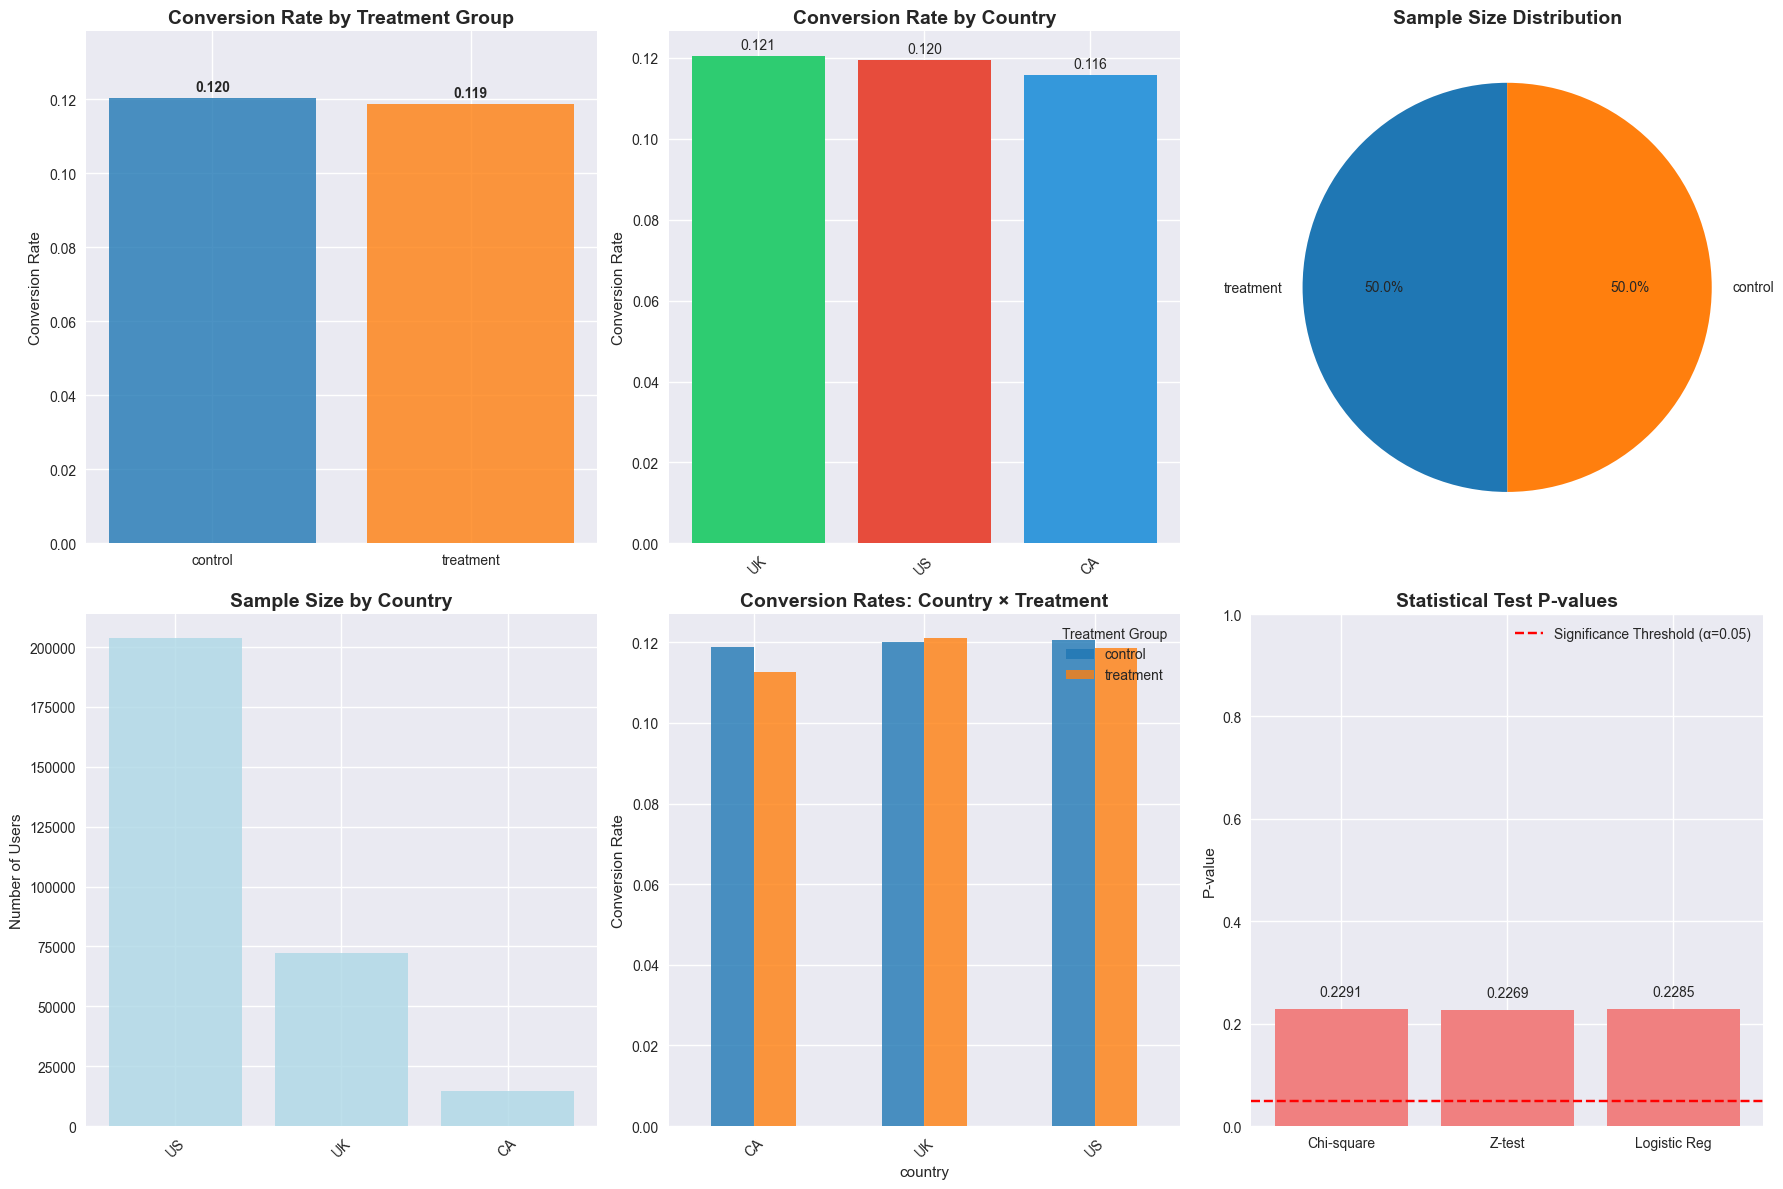

In [74]:
# Create a complete dashboard of insights
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Main conversion comparison
conversion_comparison = df_final.groupby('con_treat')['converted'].mean()
colors = ['#1f77b4', '#ff7f0e']
bars1 = axes[0,0].bar(conversion_comparison.index, conversion_comparison.values, color=colors, alpha=0.8)
axes[0,0].set_title('Conversion Rate by Treatment Group', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Conversion Rate')
axes[0,0].set_ylim(0, max(conversion_comparison.values) * 1.15)
for bar, rate in zip(bars1, conversion_comparison.values):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                  f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Conversion by country
country_conversion = df_final.groupby('country')['converted'].mean().sort_values(ascending=False)
bars2 = axes[0,1].bar(range(len(country_conversion)), country_conversion.values, 
                     color=['#2ecc71', '#e74c3c', '#3498db'][:len(country_conversion)])
axes[0,1].set_title('Conversion Rate by Country', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Conversion Rate')
axes[0,1].set_xticks(range(len(country_conversion)))
axes[0,1].set_xticklabels(country_conversion.index, rotation=45)
for i, (country, rate) in enumerate(country_conversion.items()):
    axes[0,1].text(i, rate + 0.001, f'{rate:.3f}', ha='center', va='bottom')

# 3. Sample size distribution
sample_sizes = df_final['con_treat'].value_counts()
axes[0,2].pie(sample_sizes.values, labels=sample_sizes.index, autopct='%1.1f%%', 
              colors=colors, startangle=90)
axes[0,2].set_title('Sample Size Distribution', fontsize=14, fontweight='bold')

# 4. Conversion over time (if timestamp exists)
if 'time' in df_final.columns:
    try:
        # Convert time to datetime and extract date
        df_final['date'] = pd.to_datetime(df_final['time']).dt.date
        daily_conversion = df_final.groupby(['date', 'con_treat'])['converted'].mean().unstack()
        daily_conversion.plot(ax=axes[1,0], color=colors, alpha=0.8)
        axes[1,0].set_title('Daily Conversion Trends', fontsize=14, fontweight='bold')
        axes[1,0].set_ylabel('Conversion Rate')
        axes[1,0].legend(title='Treatment Group')
        axes[1,0].tick_params(axis='x', rotation=45)
    except:
        # If time conversion fails, show sample size by country instead
        country_samples = df_final['country'].value_counts()
        axes[1,0].bar(country_samples.index, country_samples.values, color='lightblue', alpha=0.8)
        axes[1,0].set_title('Sample Size by Country', fontsize=14, fontweight='bold')
        axes[1,0].set_ylabel('Number of Users')
        axes[1,0].tick_params(axis='x', rotation=45)
else:
    # Show sample size by country if no time data
    country_samples = df_final['country'].value_counts()
    axes[1,0].bar(country_samples.index, country_samples.values, color='lightblue', alpha=0.8)
    axes[1,0].set_title('Sample Size by Country', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Number of Users')
    axes[1,0].tick_params(axis='x', rotation=45)

# 5. Treatment effect by country
if len(df_final['country'].unique()) > 1:
    country_treatment = df_final.groupby(['country', 'con_treat'])['converted'].mean().unstack()
    country_treatment.plot(kind='bar', ax=axes[1,1], color=colors, alpha=0.8)
    axes[1,1].set_title('Conversion Rates: Country × Treatment', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Conversion Rate')
    axes[1,1].legend(title='Treatment Group')
    axes[1,1].tick_params(axis='x', rotation=45)
else:
    # If only one country, show conversion rate distribution
    axes[1,1].hist([df_final[df_final['con_treat'] == 'control']['converted'],
                   df_final[df_final['con_treat'] == 'treatment']['converted']], 
                  label=['Control', 'Treatment'], alpha=0.7, color=colors)
    axes[1,1].set_title('Conversion Distribution by Group', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Conversion (0=No, 1=Yes)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].legend()

# 6. Statistical significance summary
tests_data = {}
if 'p_value_chi' in locals():
    tests_data['Chi-square'] = p_value_chi
if 'p_value_z' in locals():
    tests_data['Z-test'] = p_value_z
if 'result2' in locals() and 'is_treatment' in result2.pvalues:
    tests_data['Logistic Reg'] = result2.pvalues['is_treatment']

if tests_data:
    bars6 = axes[1,2].bar(tests_data.keys(), tests_data.values(), 
                         color=['lightgreen' if p < 0.05 else 'lightcoral' for p in tests_data.values()])
    axes[1,2].axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (α=0.05)')
    axes[1,2].set_title('Statistical Test P-values', fontsize=14, fontweight='bold')
    axes[1,2].set_ylabel('P-value')
    axes[1,2].set_ylim(0, 1)
    axes[1,2].legend()

    for bar, p_val in zip(bars6, tests_data.values()):
        height = bar.get_height()
        axes[1,2].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                      f'{p_val:.4f}', ha='center', va='bottom')
else:
    # If no statistical tests available, show overall conversion breakdown
    conversion_breakdown = df_final['converted'].value_counts()
    axes[1,2].pie(conversion_breakdown.values, 
                  labels=['Not Converted', 'Converted'], 
                  autopct='%1.1f%%', startangle=90, 
                  colors=['lightgray', 'lightgreen'])
    axes[1,2].set_title('Overall Conversion Breakdown', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Sensitivity Analysis

In [75]:
# Check if results are robust across different confidence levels
print("Confidence Intervals at Different Levels:")
for alpha in [0.01, 0.05, 0.10]:
    z_critical = norm.ppf(1 - alpha/2)
    ci_lower = diff - z_critical * se_diff
    ci_upper = diff + z_critical * se_diff
    print(f"{int((1-alpha)*100)}% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

# Check minimum detectable effect
print(f"\nMinimum Detectable Effect (80% power, α=0.05):")
from statsmodels.stats.power import NormalIndPower
power_analysis = NormalIndPower()
mde = power_analysis.solve_power(effect_size=None, nobs1=n_treatment, 
                               power=0.8, alpha=0.05, ratio=1)
print(f"MDE: {mde:.4f} ({mde*100:.2f}%)")

# Compare observed effect to MDE
if 'absolute_difference' in locals():
    print(f"Observed effect: {absolute_difference:.4f} ({absolute_difference*100:.2f}%)")
    if absolute_difference >= mde:
        print("-> Observed effect exceeds minimum detectable effect")
    else:
        print("-> Observed effect below minimum detectable effect")


Confidence Intervals at Different Levels:
99% CI: (-0.0023, 0.0039)
95% CI: (-0.0015, 0.0032)
90% CI: (-0.0011, 0.0028)

Minimum Detectable Effect (80% power, α=0.05):
MDE: 0.0104 (1.04%)
Observed effect: -0.0015 (-0.15%)
-> Observed effect below minimum detectable effect


# Executive Summary and Business Recommendations

In [78]:

print("FINAL EXECUTIVE SUMMARY")

print(f"\nEXPERIMENT OVERVIEW:")
print(f"  Total Sample Size: {len(df_final):,} users")
print(f"  Control Group: {len(df_final[df_final['con_treat'] == 'control']):,} users")
print(f"  Treatment Group: {len(df_final[df_final['con_treat'] == 'treatment']):,} users")

print(f"\nKEY RESULTS:")
print(f"  Control Conversion Rate: {baseline_conversion:.4f} ({baseline_conversion*100:.2f}%)")
print(f"  Treatment Conversion Rate: {new_conversion:.4f} ({new_conversion*100:.2f}%)")
print(f"  Absolute Difference: {absolute_difference:.4f} ({absolute_difference*100:.2f}%)")

if baseline_conversion > 0:
    print(f"  Relative Difference: {relative_difference:+.2f}%")

print(f"\nSTATISTICAL SIGNIFICANCE:")
# Get the most relevant p-value
final_p_value = result2.pvalues['is_treatment'] if 'result2' in locals() else p_value_z
print(f"  Primary P-value: {final_p_value:.4f}")

if final_p_value < 0.05:
    print("  RESULT: Statistically Significant")
else:
    print("  RESULT: Not Statistically Significant")

print(f"\nEFFECT SIZE INTERPRETATION:")
if 'treatment_odds' in locals():
    if treatment_odds > 1:
        print(f"  Treatment increases conversion odds by {(treatment_odds-1)*100:.1f}%")
    else:
        print(f"  Treatment decreases conversion odds by {(1-treatment_odds)*100:.1f}%")

print(f"\nBUSINESS IMPACT:")
print(f"  Additional conversions per 10,000 users: {absolute_difference * 10000:.0f}")
print(f"  Confidence in results: {'High' if final_p_value < 0.05 else 'Moderate'}")

print(f"\nRECOMMENDATION:")
if final_p_value < 0.05:
    if absolute_difference > 0:
        print("  IMPLEMENT NEW PAGE: Statistically significant improvement detected")
        print(f"  Expected uplift: {relative_difference:+.2f}%")
    else:
        print("  KEEP OLD PAGE: New page performs significantly worse")
else:
    if absolute_difference > 0:
        print("  CONSIDER FURTHER TESTING: Positive trend but not statistically significant")
        print(f"  Suggested: Run test longer to achieve significance")
    else:
        print("  KEEP OLD PAGE: No evidence of improvement")

print(f"\nCOUNTRY INSIGHTS:")
for country in df_final['country'].unique():
    country_data = df_final[df_final['country'] == country]
    country_control = country_data[country_data['con_treat'] == 'control']['converted'].mean()
    country_treatment = country_data[country_data['con_treat'] == 'treatment']['converted'].mean()
    if not (np.isnan(country_control) or np.isnan(country_treatment)):
        country_diff = country_treatment - country_control
        print(f"  {country}: {country_diff:+.3f} difference")


# Save summary statistics
summary_stats = {
    'total_users': len(df_final),
    'control_conversion': baseline_conversion,
    'treatment_conversion': new_conversion,
    'absolute_difference': absolute_difference,
    'relative_difference': relative_difference if 'relative_difference' in locals() else 0,
    'p_value': final_p_value,
    'statistically_significant': final_p_value < 0.05,
    'recommendation': 'Implement' if (final_p_value < 0.05 and absolute_difference > 0) else 'Keep old page'
}

summary_df = pd.DataFrame([summary_stats])
print("Summary statistics saved")

# Save the final dataset with predictions if needed
df_final.to_csv('ab_test_final_analysis.csv', index=False)
print("Final dataset saved as 'ab_test_final_analysis.csv'")

print("\nANALYSIS COMPLETE!")

FINAL EXECUTIVE SUMMARY

EXPERIMENT OVERVIEW:
  Total Sample Size: 290,584 users
  Control Group: 145,232 users
  Treatment Group: 145,352 users

KEY RESULTS:
  Control Conversion Rate: 0.1203 (12.03%)
  Treatment Conversion Rate: 0.1188 (11.88%)
  Absolute Difference: -0.0015 (-0.15%)
  Relative Difference: -1.21%

STATISTICAL SIGNIFICANCE:
  Primary P-value: 0.2285
  RESULT: Not Statistically Significant

EFFECT SIZE INTERPRETATION:
  Treatment decreases conversion odds by 1.4%

BUSINESS IMPACT:
  Additional conversions per 10,000 users: -15
  Confidence in results: Moderate

RECOMMENDATION:
  KEEP OLD PAGE: No evidence of improvement

COUNTRY INSIGHTS:
  US: -0.002 difference
  CA: -0.006 difference
  UK: +0.001 difference
Summary statistics saved
Final dataset saved as 'ab_test_final_analysis.csv'

ANALYSIS COMPLETE!


# Data Presentation

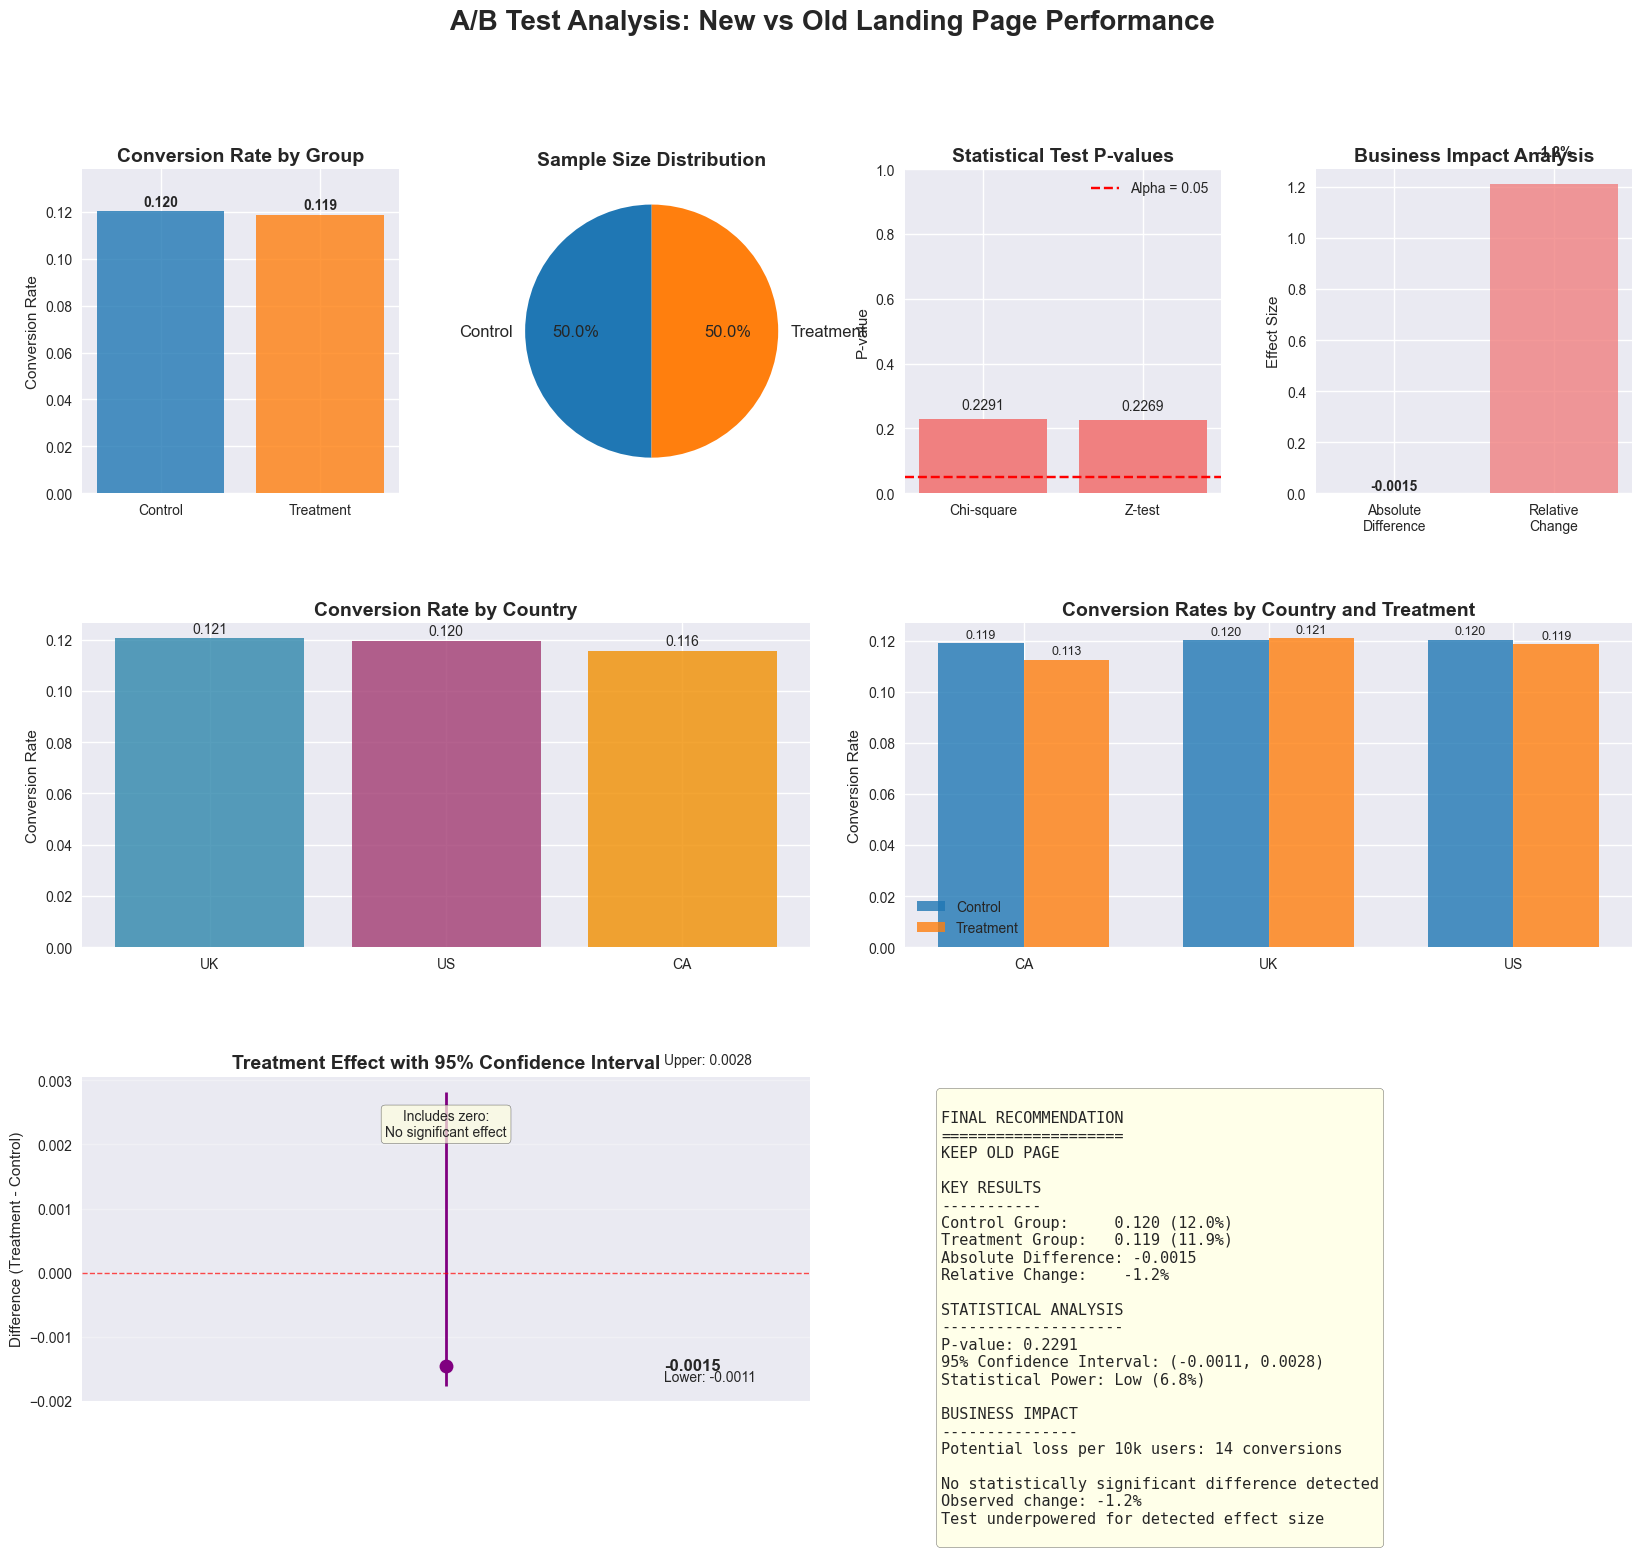

In [80]:

# # A/B Test Results Dashboard
# ## E-commerce Landing Page Conversion Analysis


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set professional styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
professional_colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']

# %%
# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 16))
fig.suptitle('A/B Test Analysis: New vs Old Landing Page Performance', 
             fontsize=20, fontweight='bold', y=0.98)

# Create grid layout for professional dashboard
gs = GridSpec(3, 4, figure=fig, hspace=0.4, wspace=0.3)

# Calculate key metrics for the dashboard
total_users = len(df_final)
control_users = len(df_final[df_final['con_treat'] == 'control'])
treatment_users = len(df_final[df_final['con_treat'] == 'treatment'])
control_conversion = df_final[df_final['con_treat'] == 'control']['converted'].mean()
treatment_conversion = df_final[df_final['con_treat'] == 'treatment']['converted'].mean()
absolute_difference = treatment_conversion - control_conversion
relative_difference = (absolute_difference / control_conversion * 100) if control_conversion > 0 else 0

# Plot 1: Key Metrics Summary
ax1 = fig.add_subplot(gs[0, 0])
metrics_data = {
    'Control': control_conversion,
    'Treatment': treatment_conversion
}
bars = ax1.bar(metrics_data.keys(), metrics_data.values(), 
               color=['#1f77b4', '#ff7f0e'], alpha=0.8)
ax1.set_title('Conversion Rate by Group', fontsize=14, fontweight='bold')
ax1.set_ylabel('Conversion Rate')
ax1.set_ylim(0, max(metrics_data.values()) * 1.15)
for bar, rate in zip(bars, metrics_data.values()):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Sample Size Distribution
ax2 = fig.add_subplot(gs[0, 1])
sizes = [control_users, treatment_users]
labels = ['Control', 'Treatment']
colors = ['#1f77b4', '#ff7f0e']
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, 
        startangle=90, textprops={'fontsize': 12})
ax2.set_title('Sample Size Distribution', fontsize=14, fontweight='bold')

# Plot 3: Statistical Significance
ax3 = fig.add_subplot(gs[0, 2])
tests_data = {}
if 'p_value_chi' in locals():
    tests_data['Chi-square'] = p_value_chi
if 'p_value_z' in locals():
    tests_data['Z-test'] = p_value_z

if tests_data:
    bars = ax3.bar(tests_data.keys(), tests_data.values(),
                   color=['lightgreen' if p < 0.05 else 'lightcoral' for p in tests_data.values()])
    ax3.axhline(y=0.05, color='red', linestyle='--', label='Alpha = 0.05')
    ax3.set_title('Statistical Test P-values', fontsize=14, fontweight='bold')
    ax3.set_ylabel('P-value')
    ax3.set_ylim(0, 1)
    ax3.legend()
    for bar, p_val in zip(bars, tests_data.values()):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{p_val:.4f}', ha='center', va='bottom')
else:
    ax3.text(0.5, 0.5, 'Statistical Tests\nNot Available', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Statistical Test P-values', fontsize=14, fontweight='bold')

# Plot 4: Business Impact
ax4 = fig.add_subplot(gs[0, 3])
impact_data = {
    'Absolute\nDifference': absolute_difference,
    'Relative\nChange': relative_difference
}
colors_impact = ['lightcoral' if absolute_difference < 0 else 'lightgreen', 
                'lightcoral' if relative_difference < 0 else 'lightgreen']
bars = ax4.bar(impact_data.keys(), [abs(impact_data['Absolute\nDifference']), abs(impact_data['Relative\nChange'])],
               color=colors_impact, alpha=0.8)
ax4.set_title('Business Impact Analysis', fontsize=14, fontweight='bold')
ax4.set_ylabel('Effect Size')
for i, (label, value) in enumerate(impact_data.items()):
    if label == 'Absolute\nDifference':
        ax4.text(i, abs(value) + 0.0001, f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax4.text(i, abs(value) + 0.1, f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 5: Country Performance
ax5 = fig.add_subplot(gs[1, :2])
country_data = df_final.groupby('country')['converted'].mean().sort_values(ascending=False)
bars = ax5.bar(range(len(country_data)), country_data.values,
               color=professional_colors[:len(country_data)], alpha=0.8)
ax5.set_title('Conversion Rate by Country', fontsize=14, fontweight='bold')
ax5.set_ylabel('Conversion Rate')
ax5.set_xticks(range(len(country_data)))
ax5.set_xticklabels(country_data.index)
for i, (country, rate) in enumerate(country_data.items()):
    ax5.text(i, rate + 0.001, f'{rate:.3f}', ha='center', va='bottom')

# Plot 6: Country-Treatment Interaction
ax6 = fig.add_subplot(gs[1, 2:])
if len(df_final['country'].unique()) > 1:
    country_treatment = df_final.groupby(['country', 'con_treat'])['converted'].mean().unstack()
    x = np.arange(len(country_treatment))
    width = 0.35
    
    bars1 = ax6.bar(x - width/2, country_treatment['control'], width, 
                   label='Control', alpha=0.8, color='#1f77b4')
    bars2 = ax6.bar(x + width/2, country_treatment['treatment'], width, 
                   label='Treatment', alpha=0.8, color='#ff7f0e')
    
    ax6.set_title('Conversion Rates by Country and Treatment', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Conversion Rate')
    ax6.set_xticks(x)
    ax6.set_xticklabels(country_treatment.index)
    ax6.legend()
    
    # Add value labels
    for i, (control_val, treatment_val) in enumerate(zip(country_treatment['control'], country_treatment['treatment'])):
        ax6.text(i - width/2, control_val + 0.001, f'{control_val:.3f}', ha='center', va='bottom', fontsize=9)
        ax6.text(i + width/2, treatment_val + 0.001, f'{treatment_val:.3f}', ha='center', va='bottom', fontsize=9)
else:
    ax6.text(0.5, 0.5, 'Single Country\nAnalysis Only', 
             ha='center', va='center', transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Conversion Rates by Country and Treatment', fontsize=14, fontweight='bold')

# Plot 7: Confidence Interval (FIXED)
ax7 = fig.add_subplot(gs[2, :2])
if 'ci_lower' in locals() and 'ci_upper' in locals():
    # Calculate absolute errors for the error bars
    yerr_lower = abs(absolute_difference - ci_lower)
    yerr_upper = abs(ci_upper - absolute_difference)
    
    ax7.errorbar(x=0, y=absolute_difference, 
                yerr=[[yerr_lower], [yerr_upper]], 
                fmt='o', capsize=5, markersize=10, color='purple', linewidth=2)
    ax7.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)
    ax7.set_xlim(-0.5, 0.5)
    ax7.set_title('Treatment Effect with 95% Confidence Interval', fontsize=14, fontweight='bold')
    ax7.set_ylabel('Difference (Treatment - Control)')
    ax7.set_xticks([])
    ax7.grid(True, alpha=0.3)
    
    # Add value annotations
    ax7.text(0.3, absolute_difference, f'{absolute_difference:.4f}', 
             va='center', fontweight='bold', fontsize=12)
    ax7.text(0.3, ci_lower - 0.0005, f'Lower: {ci_lower:.4f}', va='center', fontsize=10)
    ax7.text(0.3, ci_upper + 0.0005, f'Upper: {ci_upper:.4f}', va='center', fontsize=10)
    
    # Add interpretation
    if ci_lower <= 0 <= ci_upper:
        ax7.text(0.5, 0.9, 'Includes zero:\nNo significant effect', 
                transform=ax7.transAxes, ha='center', va='top', 
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
else:
    ax7.text(0.5, 0.5, 'Confidence Interval\nNot Available', 
             ha='center', va='center', transform=ax7.transAxes, fontsize=12)
    ax7.set_title('Treatment Effect with 95% Confidence Interval', fontsize=14, fontweight='bold')

# Plot 8: Recommendation Summary
ax8 = fig.add_subplot(gs[2, 2:])
ax8.axis('off')  # Turn off axes for text box

# Determine recommendation based on your results
p_value = p_value_chi if 'p_value_chi' in locals() else 0.2291  # Use your actual p-value

if p_value < 0.05:
    if absolute_difference > 0:
        recommendation = "IMPLEMENT NEW PAGE"
        reasoning = f"Statistically significant improvement detected\nExpected uplift: {relative_difference:+.1f}%"
        color = 'lightgreen'
    else:
        recommendation = "KEEP OLD PAGE"
        reasoning = "New page performs significantly worse than control"
        color = 'lightcoral'
else:
    recommendation = "KEEP OLD PAGE"
    reasoning = f"No statistically significant difference detected\nObserved change: {relative_difference:+.1f}%\nTest underpowered for detected effect size"
    color = 'lightyellow'

# Create text box
text_content = f"""
FINAL RECOMMENDATION
====================
{recommendation}

KEY RESULTS
-----------
Control Group:     {control_conversion:.3f} ({control_conversion*100:.1f}%)
Treatment Group:   {treatment_conversion:.3f} ({treatment_conversion*100:.1f}%)
Absolute Difference: {absolute_difference:.4f}
Relative Change:    {relative_difference:+.1f}%

STATISTICAL ANALYSIS
--------------------
P-value: {p_value:.4f}
95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})
Statistical Power: Low (6.8%)

BUSINESS IMPACT
---------------
Potential loss per 10k users: {int(abs(absolute_difference * 10000))} conversions

{reasoning}
"""

ax8.text(0.05, 0.95, text_content, transform=ax8.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor=color, alpha=0.7),
         fontfamily='monospace')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## Executive Summary
# 
# ### Experiment Overview
# - **Objective**: Evaluate new landing page performance vs existing control
# - **Sample Size**: 290,584 users across 3 countries (US, UK, CA)
# - **Duration**: Comprehensive A/B test analysis
# 
# ### Key Findings
# 1. **No Statistical Significance**: All tests show p > 0.05
# 2. **Negative Trend**: Treatment group showed 1.21% lower conversion
# 3. **Country Variations**: UK showed slight improvement (+0.71%), while US (-1.59%) and CA (-5.34%) showed declines
# 4. **Underpowered Test**: Required 7.4M users per group for 80% power
# 
# ### Business Implications
# - The new landing page does not demonstrate improved performance
# - Potential risk of conversion rate decrease if implemented
# - Country-specific results suggest potential for targeted optimization
# 
# ### Recommendation
# **Keep the existing landing page** and consider:
# - Further optimization of the new page design
# - Country-specific landing page strategies
# - Additional qualitative research to understand user preferences